# ✨ Login to wandb and Google Drive. Install pytorch-lightning when restarting runtime 

In [1]:
%matplotlib inline

# Install requirements and log into Weights and Biases, 
!pip install --quiet wandb
!wandb login

# Mount Google Drive for saving and loading models
from google.colab import drive
drive.mount('/gdrive')

!pip install --quiet pytorch-lightning
!pip install --quiet pytorch-lightning wandb

wandb: Currently logged in as: flowing-concepts-ai. Use `wandb login --relogin` to force relogin
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# ✨ Initialization and Hyperparameters

In [2]:
'''
✨ ~~~ HYPERPARAMETERS ~~~ ✨
'''
# Checkpoint options
LOAD_MODEL = False
SAVE_MODEL = False

# Model Hyperparameters
NOTE = ""
LEARNING_RATE = 0.001
BATCH_SIZE = 10
EPOCHS = 20
ACTIVATION = "RELU"
KERNAL_SIZE = 5
LOSS_FUNCTION = "CROSS ENTROPY"

# Project nomenclature for logging
HW_Q_NUMBER = "1a"    # This is the for each section of the homework
WANDB_PROJECT_NAME = "Deep Learning HW2 CNNs"

import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from collections import OrderedDict
from wandb.sdk.wandb_run import wandb_config
import wandb
import random
from torchvision.datasets import CIFAR10
from pytorch_lightning.loggers.wandb import WandbLogger
from torchmetrics.functional import accuracy
import torch.utils.data as utils_data

# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

# Each wandb run names contains info about hyperparameters for convenient identification 
WANDB_RUN_NAME = f"{HW_Q_NUMBER} {NOTE} bs:{BATCH_SIZE} lr:{LEARNING_RATE} {ACTIVATION} {LOSS_FUNCTION}"
PATH = f"/gdrive/MyDrive/pytorch_models/TEST.ckpt"

print(f"Run name: {WANDB_RUN_NAME}")
print(f"PATH: {PATH}")

wandb_logger = WandbLogger(name=WANDB_RUN_NAME, project=WANDB_PROJECT_NAME)

cuda:0
Wed Feb  8 07:05:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    25W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: flowing-concepts-ai. Use `wandb login --relogin` to force relogin


# LeNet5 PyTorch Lightning Module and Data Module ✨⚡⚡🧙⚡⚡✨ 

In [6]:

class LeNetCNN(pl.LightningModule):

  def __init__(self):
    super(LeNetCNN, self).__init__()

    self.c1 = nn.Conv2d(3, 6, kernel_size=(KERNAL_SIZE, KERNAL_SIZE), stride=1, padding=0, )
    self.s2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    self.c3 = nn.Conv2d(6, 16, kernel_size=(KERNAL_SIZE, KERNAL_SIZE), stride=1, padding=0, )
    self.s4 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    if KERNAL_SIZE == 5:
      self.fc5 = nn.Linear(400, 120)

    elif KERNAL_SIZE == 3:
      self.fc5 = nn.Linear(576, 120)


    self.fc6 = nn.Linear(120, 84)
    self.fc7 = nn.Linear(84, 10)

  def forward(self, x):

      if ACTIVATION == "RELU":

        x = self.c1(x)
        x = torch.relu(x)
        x = self.s2(x)
        x = self.c3(x)
        x = torch.relu(x)
        x = self.s4(x)

        # Reshape for fully connected layers
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)

        x = self.fc5(x)
        x = torch.relu(x)
        x = self.fc6(x)
        x = torch.relu(x)
        x = self.fc7(x)

      if ACTIVATION == "SIGMOID":

        x = self.c1(x)
        x = torch.sigmoid(x)
        x = self.s2(x)
        x = self.c3(x)
        x = torch.sigmoid(x)
        x = self.s4(x)

        # Reshape for fully connected layers
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)

        x = self.fc5(x)
        x = torch.sigmoid(x)
        x = self.fc6(x)
        x = torch.sigmoid(x)
        x = self.fc7(x)

      if ACTIVATION == "TANH":

        x = self.c1(x)
        x = torch.tanh(x)
        x = self.s2(x)
        x = self.c3(x)
        x = torch.tanh(x)
        x = self.s4(x)

        # Reshape for fully connected layers
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)

        x = self.fc5(x)
        x = torch.tanh(x)
        x = self.fc6(x)
        x = torch.tanh(x)
        x = self.fc7(x)

      # Perform softmax on the output
      output = F.log_softmax(x, dim=1)
      return output

  def loss_function(self, logits, labels):

    if LOSS_FUNCTION == "CROSS ENTROPY":
      loss = F.nll_loss(logits, labels)

    if LOSS_FUNCTION == "MSE":
 
      # Convert labels to one-hot vectors for Mean Squared Error loss
      one_hot_labels = F.one_hot(labels, num_classes=10)
      one_hot_labels = one_hot_labels.to(dtype=torch.float32)
      loss = F.mse_loss(logits, one_hot_labels) 

    return loss


  def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.forward(x)
      loss = self.loss_function(logits, y)
      self.log('train_loss', loss)
      return loss

  def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      logits = self.forward(x)
      loss = self.loss_function(logits, y)
      self.log('val_loss', loss)

  def _shared_eval_step(self, batch, batch_idx):
      x, y = batch
      y_hat = self.forward(x)
      loss = self.loss_function(y_hat, y)
      acc = accuracy(y_hat, y, task='multiclass', num_classes=10)
      return loss, acc

  def test_step(self, batch, batch_idx):
      loss, acc = self._shared_eval_step(batch, batch_idx)
      metrics = {"test_acc": acc, "test_loss": loss}
      self.log_dict(metrics)
      return metrics     

  def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(), lr=LEARNING_RATE)
    return optimizer


  def test_dataloader(self):
    self.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    self.test_data = CIFAR10(os.getcwd(), train=False, download=True, transform=self.transform)
    return DataLoader(self.test_data, batch_size=BATCH_SIZE)


# Data Module

class CIFAR10_DataModule(pl.LightningDataModule):

  def __init__(self):
    super().__init__()
    self.download_dir = os.getcwd()
    self.batch_size = BATCH_SIZE
    self.transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  def setup(self, stage):

    full_dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.transform)
    self.train_data, self.valid_data = utils_data.random_split(full_dataset, [0.75, 0.25], generator=torch.Generator().manual_seed(42))
    self.test_data = CIFAR10(self.download_dir, train=False, download=True, transform=self.transform)

  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.valid_data, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.test_data, batch_size=self.batch_size)

# Callbacks

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Callback to test on test set at the end of every epoch

class TestSetCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        model = pl_module
        test_dataloader = pl_module.test_dataloader()

        # perform testing on the test set
        test_loss, test_acc = self.test_model(model, test_dataloader)
        # print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        model.log('Test Loss per epoch', test_loss)
        model.log('Test Accuracy', test_acc)

    def test_model(self, model, test_dataloader):
        model.eval()
        total_loss = 0.0
        total_acc = 0.0

        for i, (x, y) in enumerate(test_dataloader):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                output = model(x)
                loss = self.loss_fn(output, y)
                total_loss += loss.item()

                _, pred = torch.max(output, dim=1)
                total_acc += (pred == y).sum().item()

        avg_loss = total_loss / len(test_dataloader)
        avg_acc = total_acc / len(test_dataloader.dataset)

        return avg_loss, avg_acc

    def loss_fn(self, output, target):
        return torch.nn.functional.cross_entropy(output, target)

# Training

In [ ]:
# Load model or create new one
if not LOAD_MODEL:
  print("NEW MODEL CREATED")
  model = LeNetCNN()

else:
  print("Trained model loaded")
  model = LeNetCNN.load_from_checkpoint("/content/Deep Learning HW2 CNNs/92kl5as5/checkpoints/epoch=19-step=75000.ckpt")

# Instantiate data module
data_module = CIFAR10_DataModule()

# Configure trainer
trainer = pl.Trainer(
    default_root_dir=PATH,  # save to Google Drive
    accelerator="gpu", devices=-1,
    max_epochs=EPOCHS,
    logger=wandb_logger,
    callbacks=[
              TestSetCallback(),
              # FilterVisualizationCallback(model, 'c3')
              ]
    )

# Train the model
trainer.fit(model, data_module)

# Visualize Feature Maps in a trained network

Files already downloaded and verified


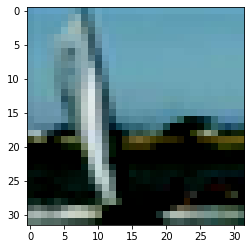

<Figure size 1440x1152 with 0 Axes>

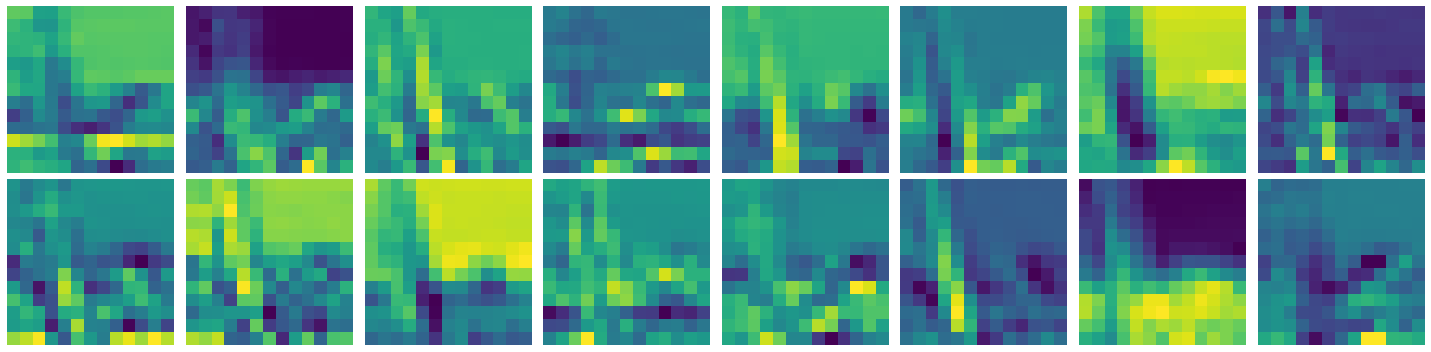

The image is predicted to belong to class:  8 which is a ship


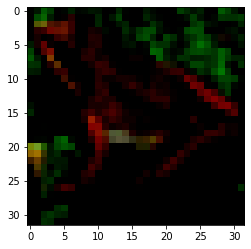

<Figure size 1440x1152 with 0 Axes>

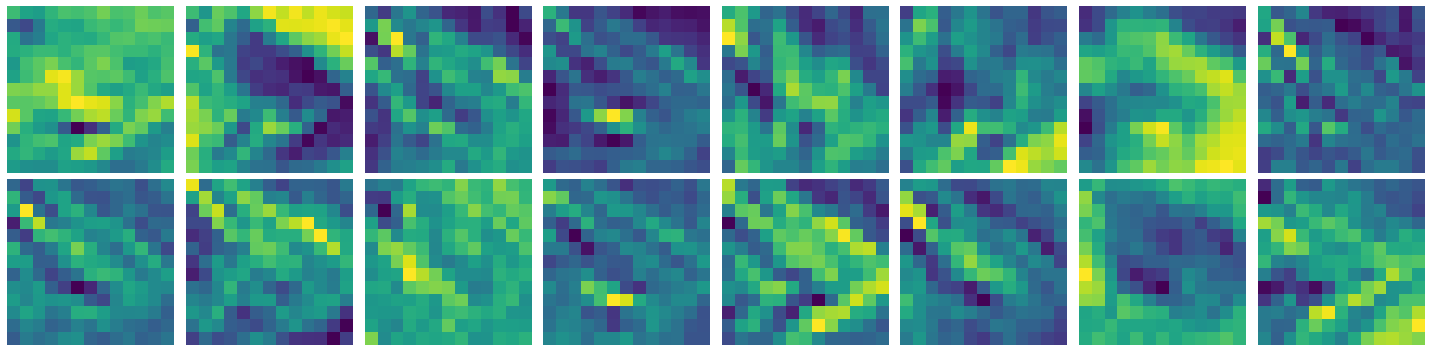

The image is predicted to belong to class:  6 which is a frog


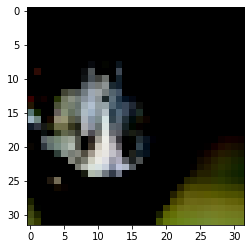

<Figure size 1440x1152 with 0 Axes>

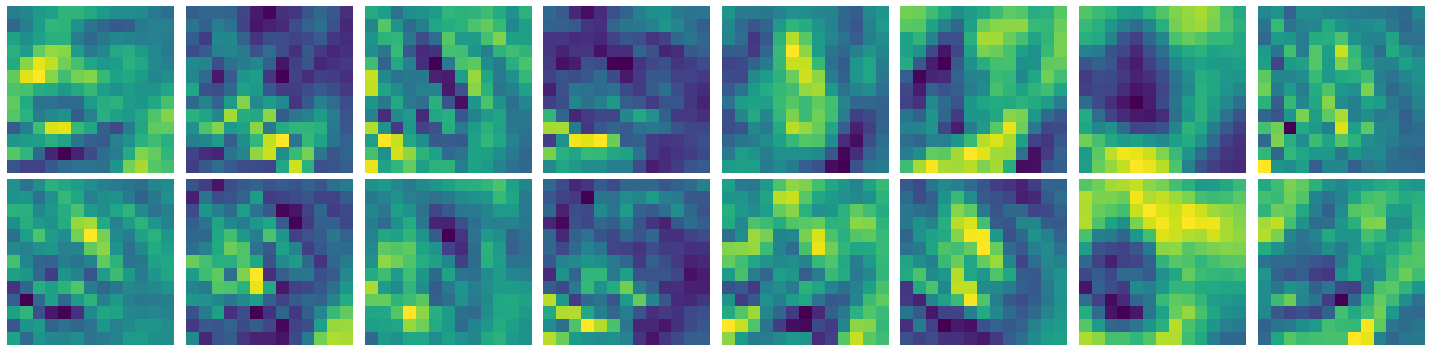

The image is predicted to belong to class:  3 which is a cat


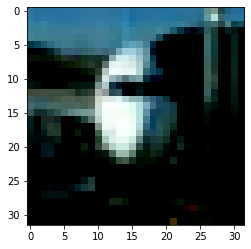

<Figure size 1440x1152 with 0 Axes>

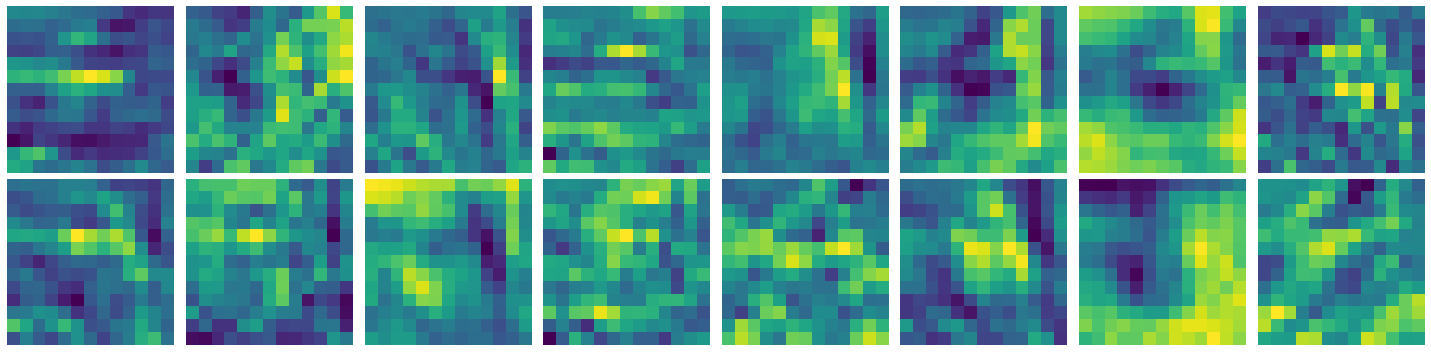

The image is predicted to belong to class:  8 which is a ship


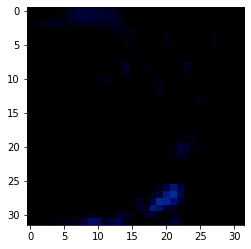

<Figure size 1440x1152 with 0 Axes>

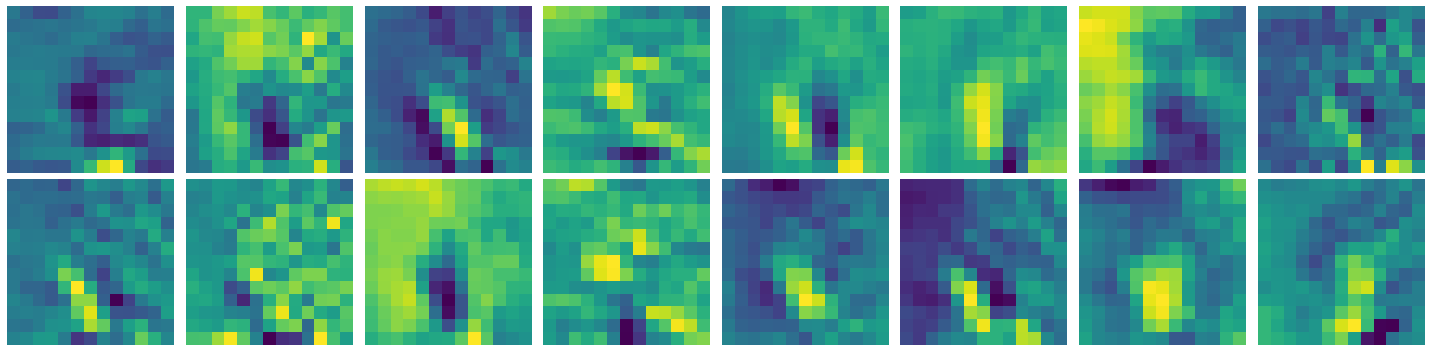

The image is predicted to belong to class:  2 which is a bird


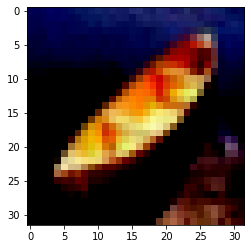

<Figure size 1440x1152 with 0 Axes>

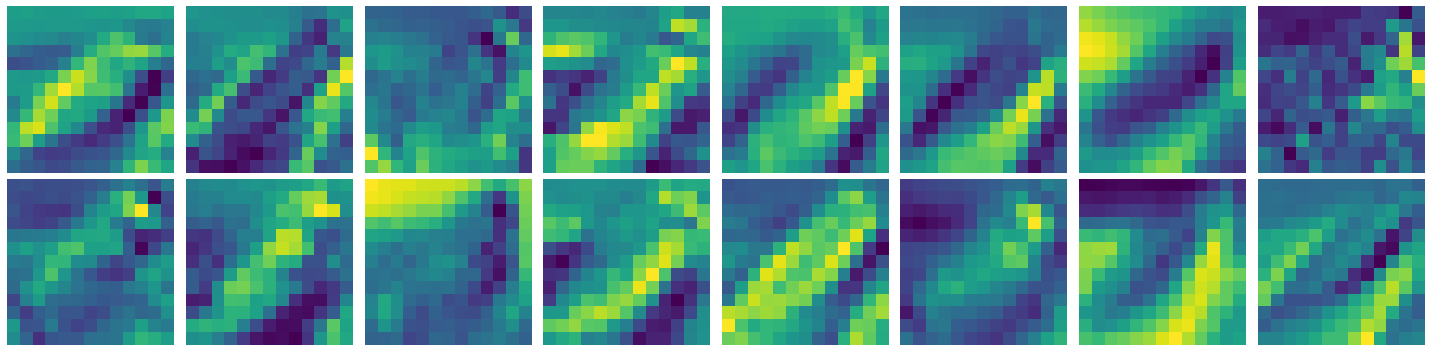

The image is predicted to belong to class:  8 which is a ship


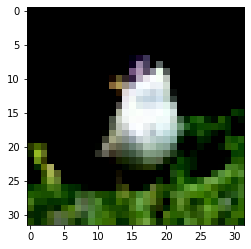

<Figure size 1440x1152 with 0 Axes>

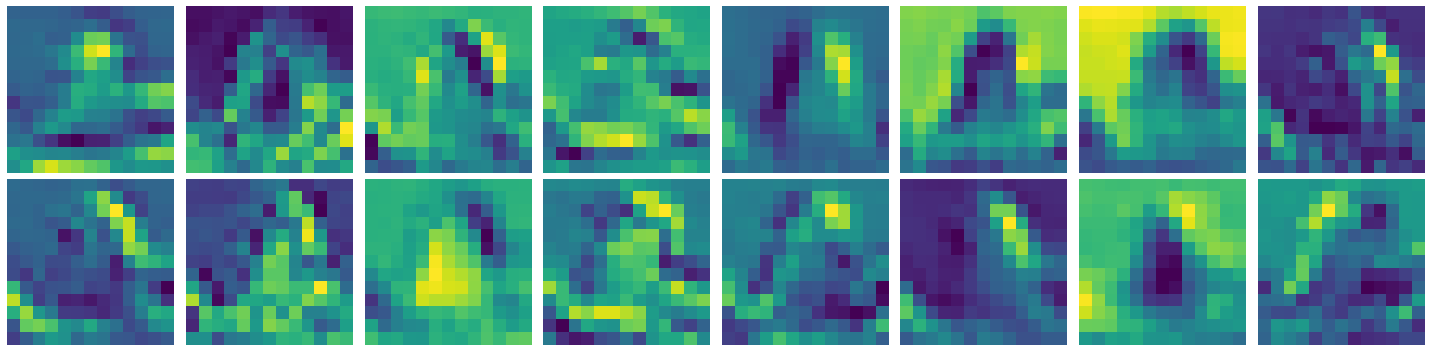

The image is predicted to belong to class:  5 which is a dog


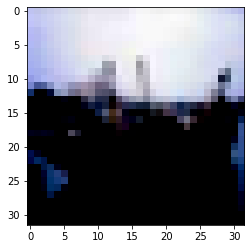

<Figure size 1440x1152 with 0 Axes>

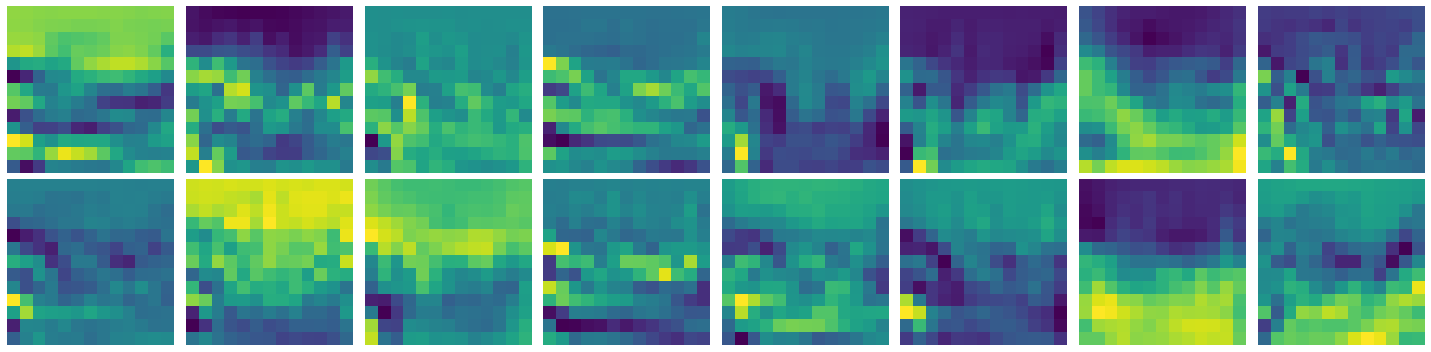

The image is predicted to belong to class:  8 which is a ship


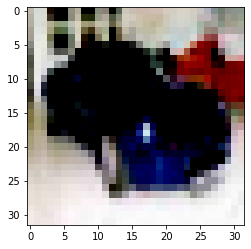

<Figure size 1440x1152 with 0 Axes>

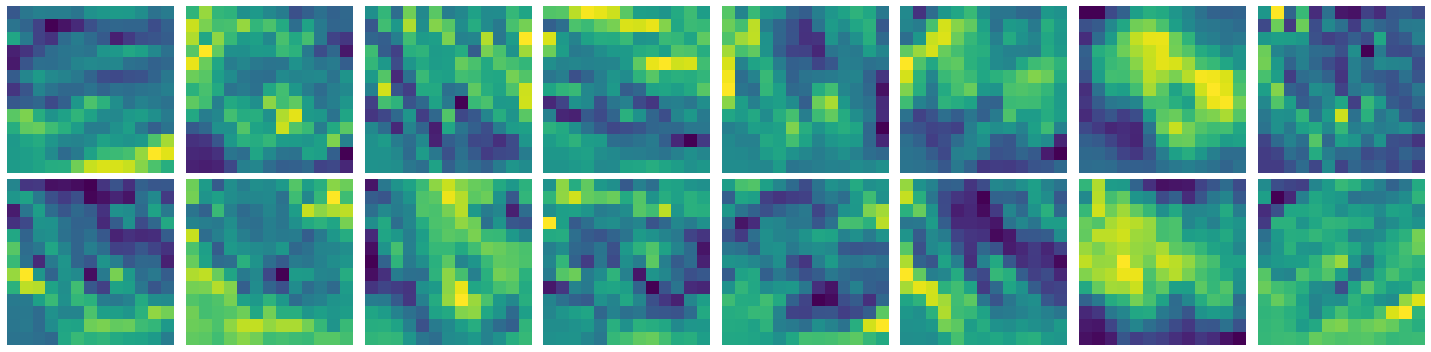

The image is predicted to belong to class:  1 which is a automobile


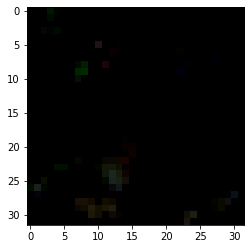

<Figure size 1440x1152 with 0 Axes>

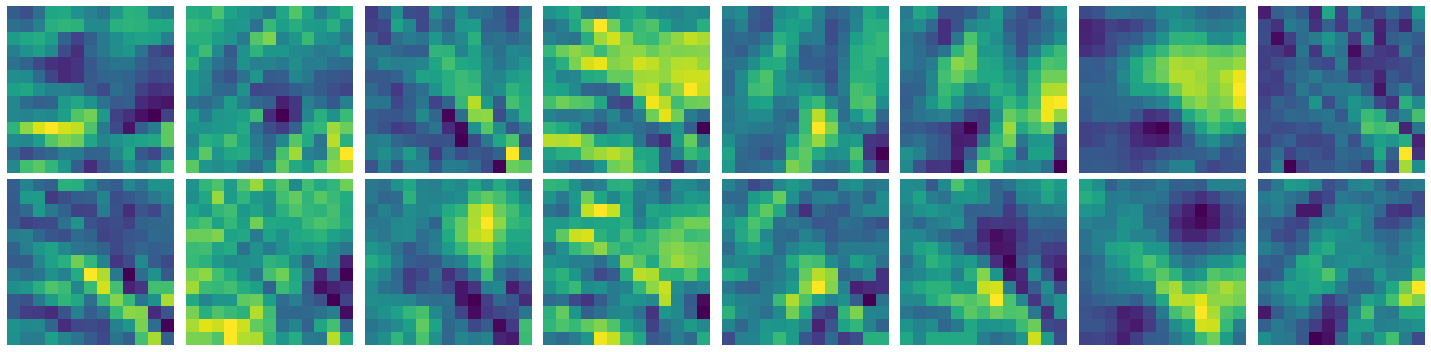

The image is predicted to belong to class:  2 which is a bird


In [ ]:
import torchvision
import numpy.random as random

# Load trained model
# model = LeNetCNN.load_from_checkpoint("/content/Deep Learning HW2 CNNs/8ojfoars/checkpoints/epoch=19-step=75000.ckpt")

# disable randomness, dropout, etc...
model.eval()

# Load the CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Visualize the initial image
def visualize_input_image(img):
  img = img.detach().cpu().numpy()
  img = img[0,:,:,:]
  img = np.transpose(img, (1,2,0))
  plt.imshow(img)
  # plt.show()

# Hook function to visualize feature maps
def c3_feature_map_visualization_hook_fn(module, input, output):

  n_images = output.shape[1]
  activations = output
  activations = activations.detach().cpu().numpy()
  feature_maps = []

  for feature_map in range(n_images):
    feature_maps.append(activations[0,feature_map,:,:])

  plt.figure(figsize=(20,n_images))
  fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(20,5))

  for i, axi in enumerate(ax.flat):

      axi.imshow(feature_maps[i])
      axi.axis('off')
  
  plt.tight_layout()
  plt.show()

# Register hook in last convolution layer
c3_feature_map_visualization_hook = model.c3.register_forward_hook(c3_feature_map_visualization_hook_fn)

# Dictionary of class names and their corresponding prediction integer
class_names = {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
}

for i in range(10):
  # Preprocess an image from the CIFAR10 dataset
  random_int = random.randint(0, 999)
  img, label = dataset[random_int]
  img = img.unsqueeze(0)

  # Visulaize input image
  visualize_input_image(img)

  # Make a prediction
  with torch.no_grad():
      prediction = model(img)

  # Decode the prediction
  _, prediction = torch.max(prediction, 1)
  predicted_class = prediction.item()
  print("The image is predicted to belong to class: ", predicted_class, "which is a", class_names[str(predicted_class)])

# Remove hook
c3_feature_map_visualization_hook.remove()
del c3_feature_map_visualization_hook

# 3. CNN with 5 convolution layers ✨⚡⚡🧙⚡⚡✨
with 3x3 kernels and corresponding 2x2 average 
pooling with stride 1. Use padding at each convolution layer so that the size of the output 
matches the input after each convolution layer. Train the network for any choice of model 
parameters.

In [ ]:


class FiveLayerCNN(pl.LightningModule):

  def __init__(self):
    super(FiveLayerCNN, self).__init__()

    # input image is 32 x 32 
    # output of first layer is 28 x 28 .  filter was 5 and stride was 1. So it was filter size - stride = 4. 


    self.c1 = nn.Conv2d(3, 6, kernel_size=(3, 3), stride=1, padding=0, )
    # 6  30 x 30

    self.s2 = nn.MaxPool2d(kernel_size=(2, 2), stride=1)
    #6  15 x 15

    self.c3 = nn.Conv2d(6, 12, kernel_size=(3, 3), stride=1, padding=3, )
    #12 7 x 7

    self.s4 =  nn.MaxPool2d(kernel_size=(2, 2), stride=1)

    self.c5 = nn.Conv2d(12, 24, kernel_size=(3, 3), stride=1, padding=0, )
    self.s6 =  nn.MaxPool2d(kernel_size=(2, 2), stride=1)

    self.c7 = nn.Conv2d(24, 48, kernel_size=(3, 3), stride=1, padding=0, )
    self.s8 =  nn.MaxPool2d(kernel_size=(2, 2), stride=1)

    self.c9 = nn.Conv2d(48, 96, kernel_size=(3, 3), stride=1, padding=0, )
    self.s10 =  nn.MaxPool2d(kernel_size=(2, 2), stride=1)


    self.fc5 = nn.Linear(12288, 120)
    self.fc6 = nn.Linear(120, 84)
    self.fc7 = nn.Linear(84, 10)

  def forward(self, x):

      if ACTIVATION == "RELU":

        x = self.c1(x)

        # print("c1", x.shape)

        x = torch.relu(x)
        x = self.s2(x)
        # print("s2", x.shape)
        x = self.c3(x)
        # print("c3", x.shape)
        x = torch.relu(x)
        x = self.s4(x)

        # Reshape for fully connected layers
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)

        x = self.fc5(x)
        x = torch.relu(x)
        x = self.fc6(x)
        x = torch.relu(x)
        x = self.fc7(x)

      if ACTIVATION == "SIGMOID":

        x = self.c1(x)
        x = torch.sigmoid(x)
        x = self.s2(x)
        x = self.c3(x)
        x = torch.sigmoid(x)
        x = self.s4(x)

        # Reshape for fully connected layers
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)

        x = self.fc5(x)
        x = torch.sigmoid(x)
        x = self.fc6(x)
        x = torch.sigmoid(x)
        x = self.fc7(x)

      if ACTIVATION == "TANH":

        x = self.c1(x)
        x = torch.tanh(x)
        x = self.s2(x)
        x = self.c3(x)
        x = torch.tanh(x)
        x = self.s4(x)

        # Reshape for fully connected layers
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)

        x = self.fc5(x)
        x = torch.tanh(x)
        x = self.fc6(x)
        x = torch.tanh(x)
        x = self.fc7(x)

      # Perform softmax on the output
      output = F.log_softmax(x, dim=1)
      return output

  def loss_function(self, logits, labels):

    if LOSS_FUNCTION == "CROSS ENTROPY":
      loss = F.nll_loss(logits, labels)

    if LOSS_FUNCTION == "MSE":
 
      # Convert labels to one-hot vectors for Mean Squared Error loss
      one_hot_labels = F.one_hot(labels, num_classes=10)
      one_hot_labels = one_hot_labels.to(dtype=torch.float32)
      loss = F.mse_loss(logits, one_hot_labels) 

    return loss


  def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.forward(x)
      loss = self.loss_function(logits, y)
      self.log('train_loss', loss)
      return loss

  def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      logits = self.forward(x)
      loss = self.loss_function(logits, y)
      self.log('val_loss', loss)

  def _shared_eval_step(self, batch, batch_idx):
      x, y = batch
      y_hat = self.forward(x)
      loss = self.loss_function(y_hat, y)
      acc = accuracy(y_hat, y, task='multiclass', num_classes=10)
      return loss, acc

  def test_step(self, batch, batch_idx):
      loss, acc = self._shared_eval_step(batch, batch_idx)
      metrics = {"test_acc": acc, "test_loss": loss}
      self.log_dict(metrics)
      return metrics     

  def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(), lr=LEARNING_RATE)
    return optimizer


  def test_dataloader(self):
    self.transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    self.test_data = CIFAR10(os.getcwd(), train=False, download=True, transform=self.transform)
    return DataLoader(self.test_data, batch_size=BATCH_SIZE)


# Data Module

class CIFAR10_DataModule(pl.LightningDataModule):

  def __init__(self):
    super().__init__()
    self.download_dir = os.getcwd()
    self.batch_size = BATCH_SIZE
    self.transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  def setup(self, stage):

    full_dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.transform)
    self.train_data, self.valid_data = utils_data.random_split(full_dataset, [0.75, 0.25], generator=torch.Generator().manual_seed(42))
    self.test_data = CIFAR10(self.download_dir, train=False, download=True, transform=self.transform)

  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.valid_data, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.test_data, batch_size=self.batch_size)

# Load model or create new one
if not LOAD_MODEL:
  print("NEW MODEL CREATED")
  model = FiveLayerCNN()

else:
  print("Trained model loaded")
  model = FiveLayerCNN.load_from_checkpoint("/content/Deep Learning HW2 CNNs/sfy2tmq6/checkpoints/epoch=19-step=75000.ckpt")

# Instantiate data module
data_module = CIFAR10_DataModule()

# Configure trainer
trainer = pl.Trainer(
    default_root_dir=PATH,  # save to Google Drive
    accelerator="gpu", devices=-1,
    max_epochs=EPOCHS,
    logger=wandb_logger,
    callbacks=[
              TestSetCallback(),
              # FilterVisualizationCallback(model, 'c3')
              ]
    )

# Train the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trained model loaded
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name | Type      | Params
------------------------------------
0  | c1   | Conv2d    | 168   
1  | s2   | MaxPool2d | 0     
2  | c3   | Conv2d    | 660   
3  | s4   | MaxPool2d | 0     
4  | c5   | Conv2d    | 2.6 K 
5  | s6   | MaxPool2d | 0     
6  | c7   | Conv2d    | 10.4 K
7  | s8   | MaxPool2d | 0     
8  | c9   | Conv2d    | 41.6 K
9  | s10  | MaxPool2d | 0     
10 | fc5  | Linear    | 1.5 M 
11 | fc6  | Linear    | 10.2 K
12 | fc7  | Linear    | 850   
------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.164     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# 🚀 Save trained model 

In [ ]:
# if SAVE_MODEL:
#   print(f"PATH: {PATH}")
#   EPOCH = "EPOCH += epochs"
#   LOSS = "I haven't configured this to log the loss yet"

#   torch.save({
#               'epoch': EPOCH,
#               'model_state_dict': model.state_dict(),
#               'optimizer_state_dict': optimizer.state_dict(),
#               'loss': LOSS,
#               }, PATH)
  
#   print("Model saved.")